In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import scanpy as sc
import anndata
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
import sys
sys.path.append('../miso')

In [3]:
from miso.hist_features import get_features
from miso.utils import *
from miso import Miso
from PIL import Image
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
Image.MAX_IMAGE_PIXELS = None
Image.MAX_IMAGE_PIXELS = None
import torch
import random

seed=100
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA is available. GPU:", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print("CUDA is not available. Using CPU.")

CUDA is available. GPU: NVIDIA H100 80GB HBM3


In [4]:
rna = sc.read_h5ad('../../coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_RNA.h5ad')
                        
protein = sc.read_h5ad('../../coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_ADT.h5ad')

In [5]:
#Load data and perform necessary preprocessing

rna = preprocess(rna,modality='rna')


protein = preprocess(protein,modality='protein')

In [6]:
model = Miso([rna,protein],ind_views='all',combs='all',sparse=False,device=device)
model.train()
np.save('emb.npy', model.emb)

Training network for modality 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training network for modality 2:   0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
locs = sc.read_h5ad('../../coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_RNA.h5ad').obsm['spatial']
      

In [9]:
def plot_on_histology(clusters, locs, im, scale, s=10):
    #locs = locs*scale
    #locs = locs.round().astype('int')
    #im = im[(locs['4'].min()-10):(locs['4'].max()+10),(locs['5'].min()-10):(locs['5'].max()+10)]
    #locs = locs-locs.min()+10
    cmap1 = ['#f4f1de',  '#81b29a', '#f2cc8f', '#3d405b','#e07a5f',]
    #cmap1 = mcolors.ListedColormap([cmap_tab70(np.array(i)) for i in range(len(np.unique(clusters)))])
    ##plt.imshow(im, alpha=0.7); 
    plot = sns.scatterplot(x=locs[:,0], y=locs[:,1], hue = clusters, 
                           palette=cmap1, s=s); 
    plt.axis('off'); 
    return plot

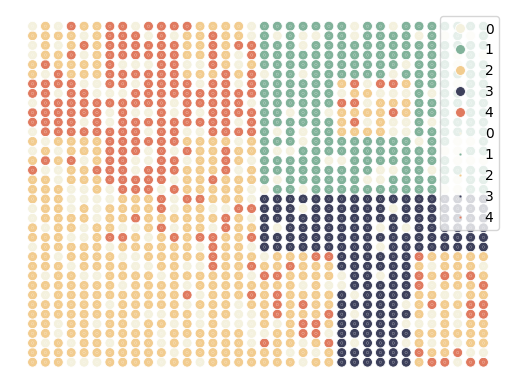

In [11]:
import seaborn as sns
clusters = model.cluster(n_clusters=5)
#im_lowres = plt.imread('tissue_hires_image.png')
plot_on_histology(clusters,locs,None, 1,s=50)

cmap1 = ['#f4f1de',  '#81b29a', '#f2cc8f', '#3d405b','#e07a5f',]
#cmap1 = mcolors.ListedColormap([cmap_tab70(np.array(i)) for i in range(len(np.unique(clusters)))])
##plt.imshow(im, alpha=0.7); 
plot = sns.scatterplot(x=locs[:,0], y=locs[:,1], hue = clusters, 
                       palette=cmap1, s=3); 
plt.axis('off'); 

In [13]:
rna

array([[2.7080503, 1.3862944, 0.       , ..., 2.3978953, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.3862944,
        0.       ],
       ...,
       [0.       , 2.8332133, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.3862944,
        0.       ],
       [2.4849067, 0.       , 0.       , ..., 0.       , 3.3322046,
        1.9459102]], dtype=float32)

In [61]:
adata = anndata.AnnData(rna)
adata.obs['leiden'] = clusters
adata.obsm['spatial'] = locs

In [62]:
custom_palette = ['#f4f1de', '#81b29a', '#f2cc8f', '#3d405b', '#e07a5f',]
annotation_mapping = {
    0: 'backgr'  ,
    1: 'factor2',
    2: 'factor3',
    3: 'factor4',
    4: 'factor1', 
}

adata.obs['leiden'] = adata.obs['leiden'].map(annotation_mapping)


In [65]:
adata.obs

,leiden
0,factor2
1,factor1
2,factor2
3,factor2
4,factor3
...,...
1291,factor3
1292,factor3
1293,factor4
1294,factor1


Text(0, 0.5, '')

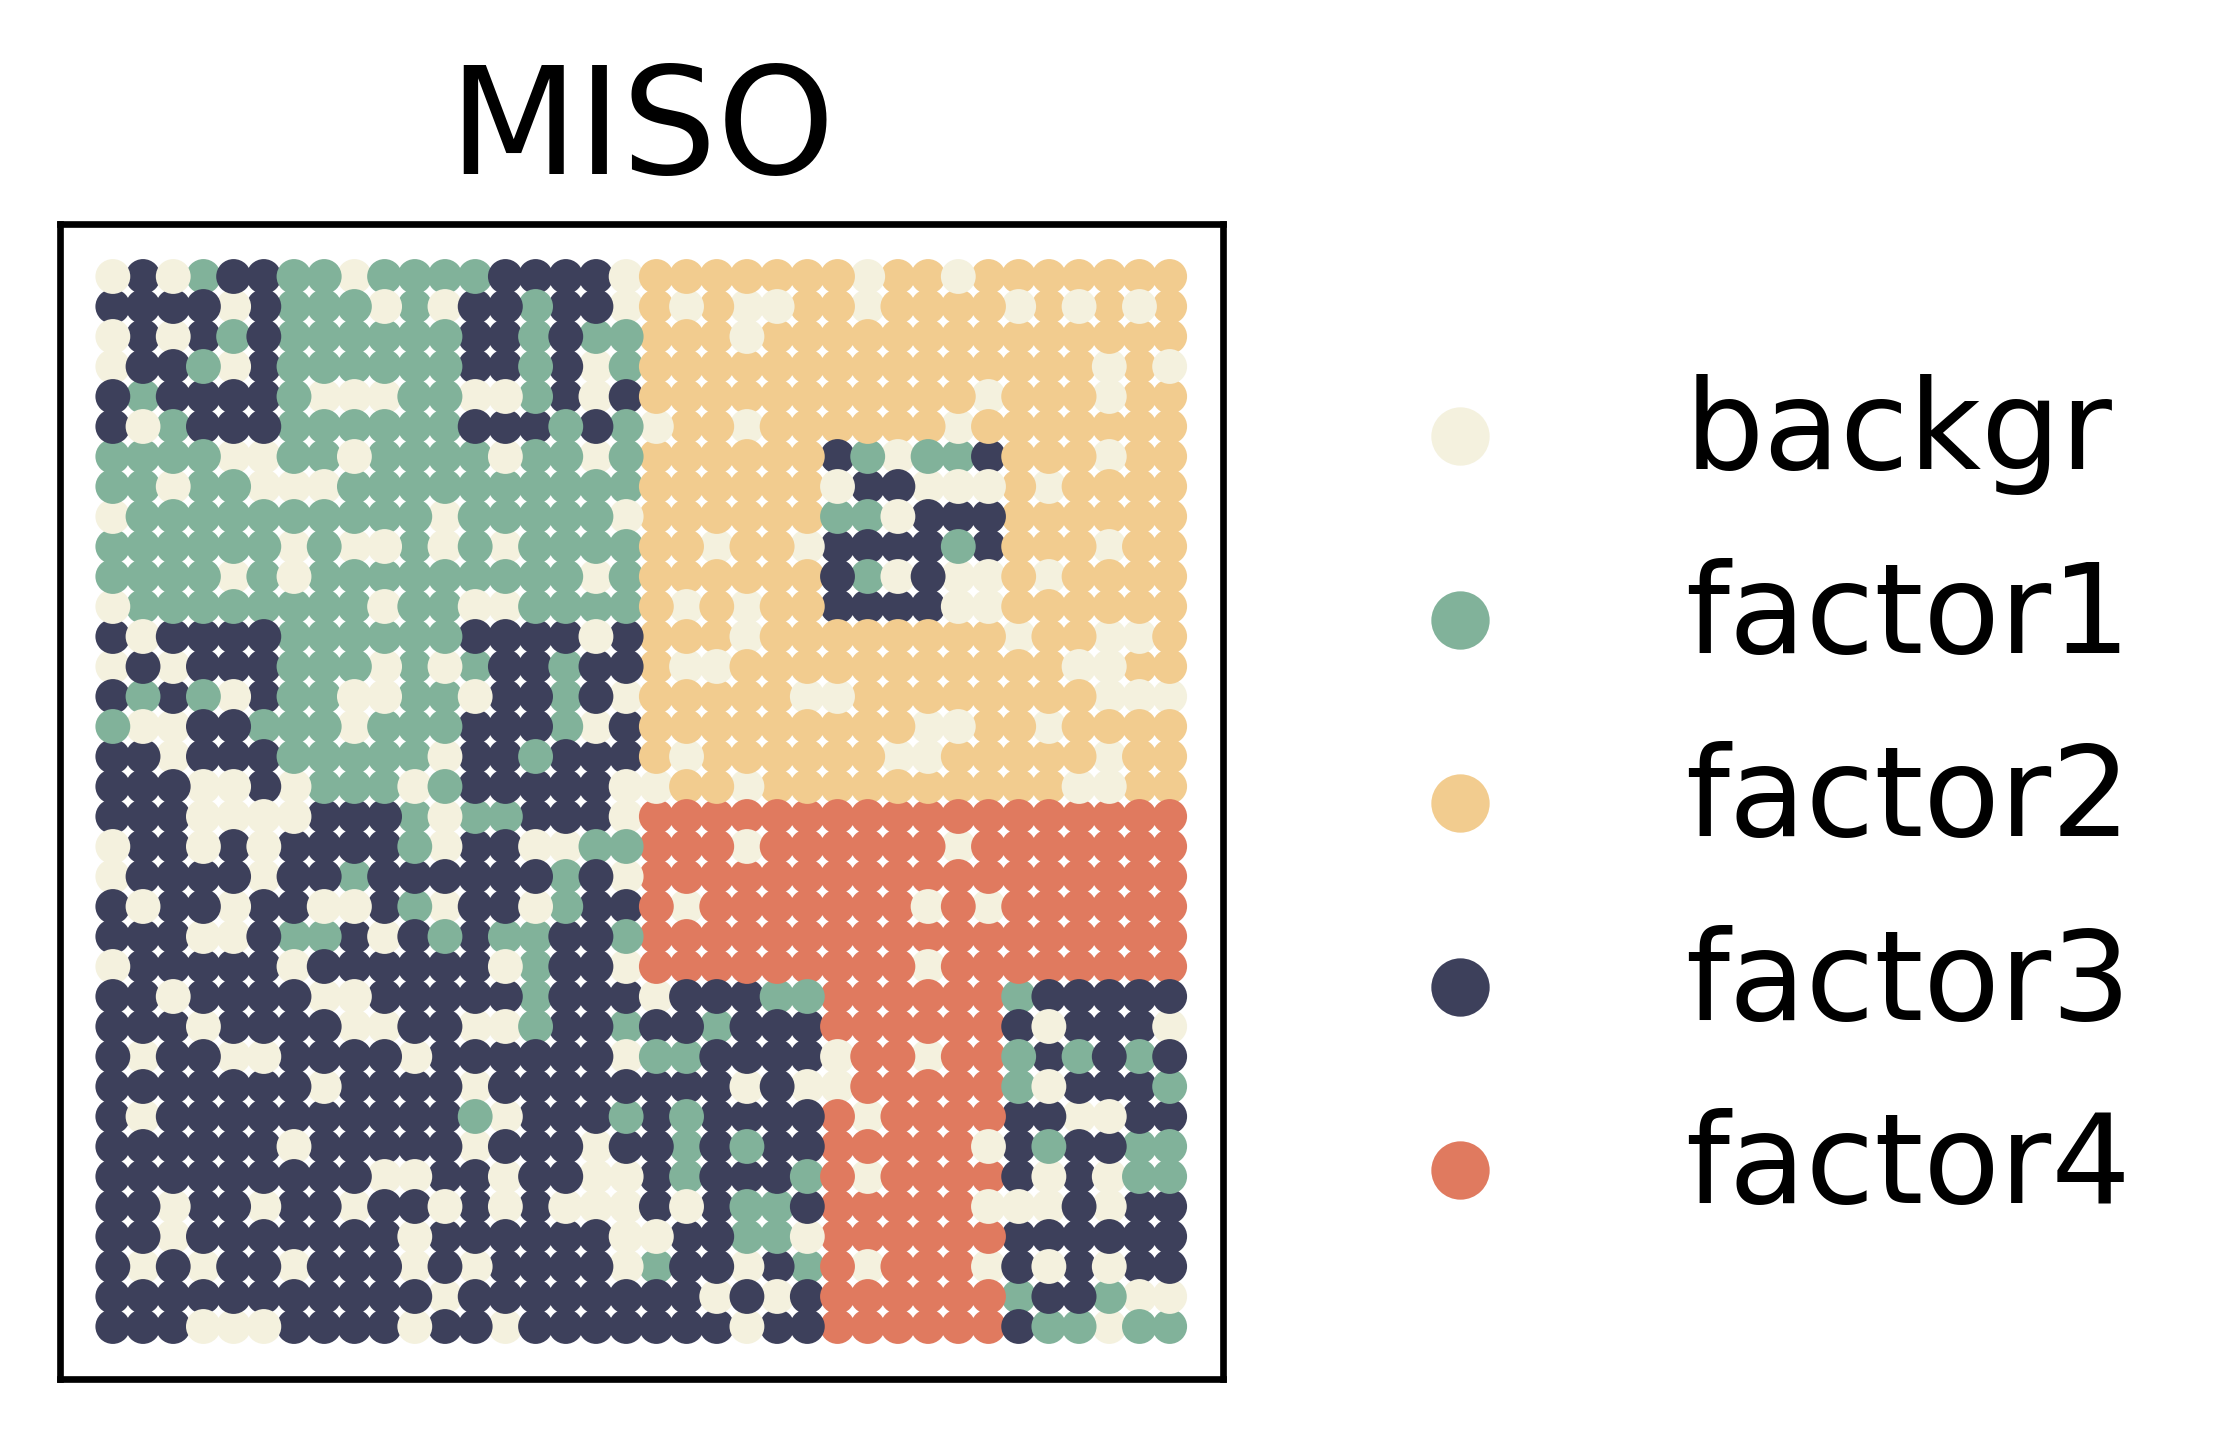

In [63]:
plt.rcParams['figure.figsize'] = (2.5,2.5)
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['figure.dpi'] = 600

sc.pl.embedding(adata, basis='spatial', color='leiden', 
                title='MISO', s=70, show=False,palette=custom_palette)
plt.xlabel('')
plt.ylabel('')


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0, 0.5, '')

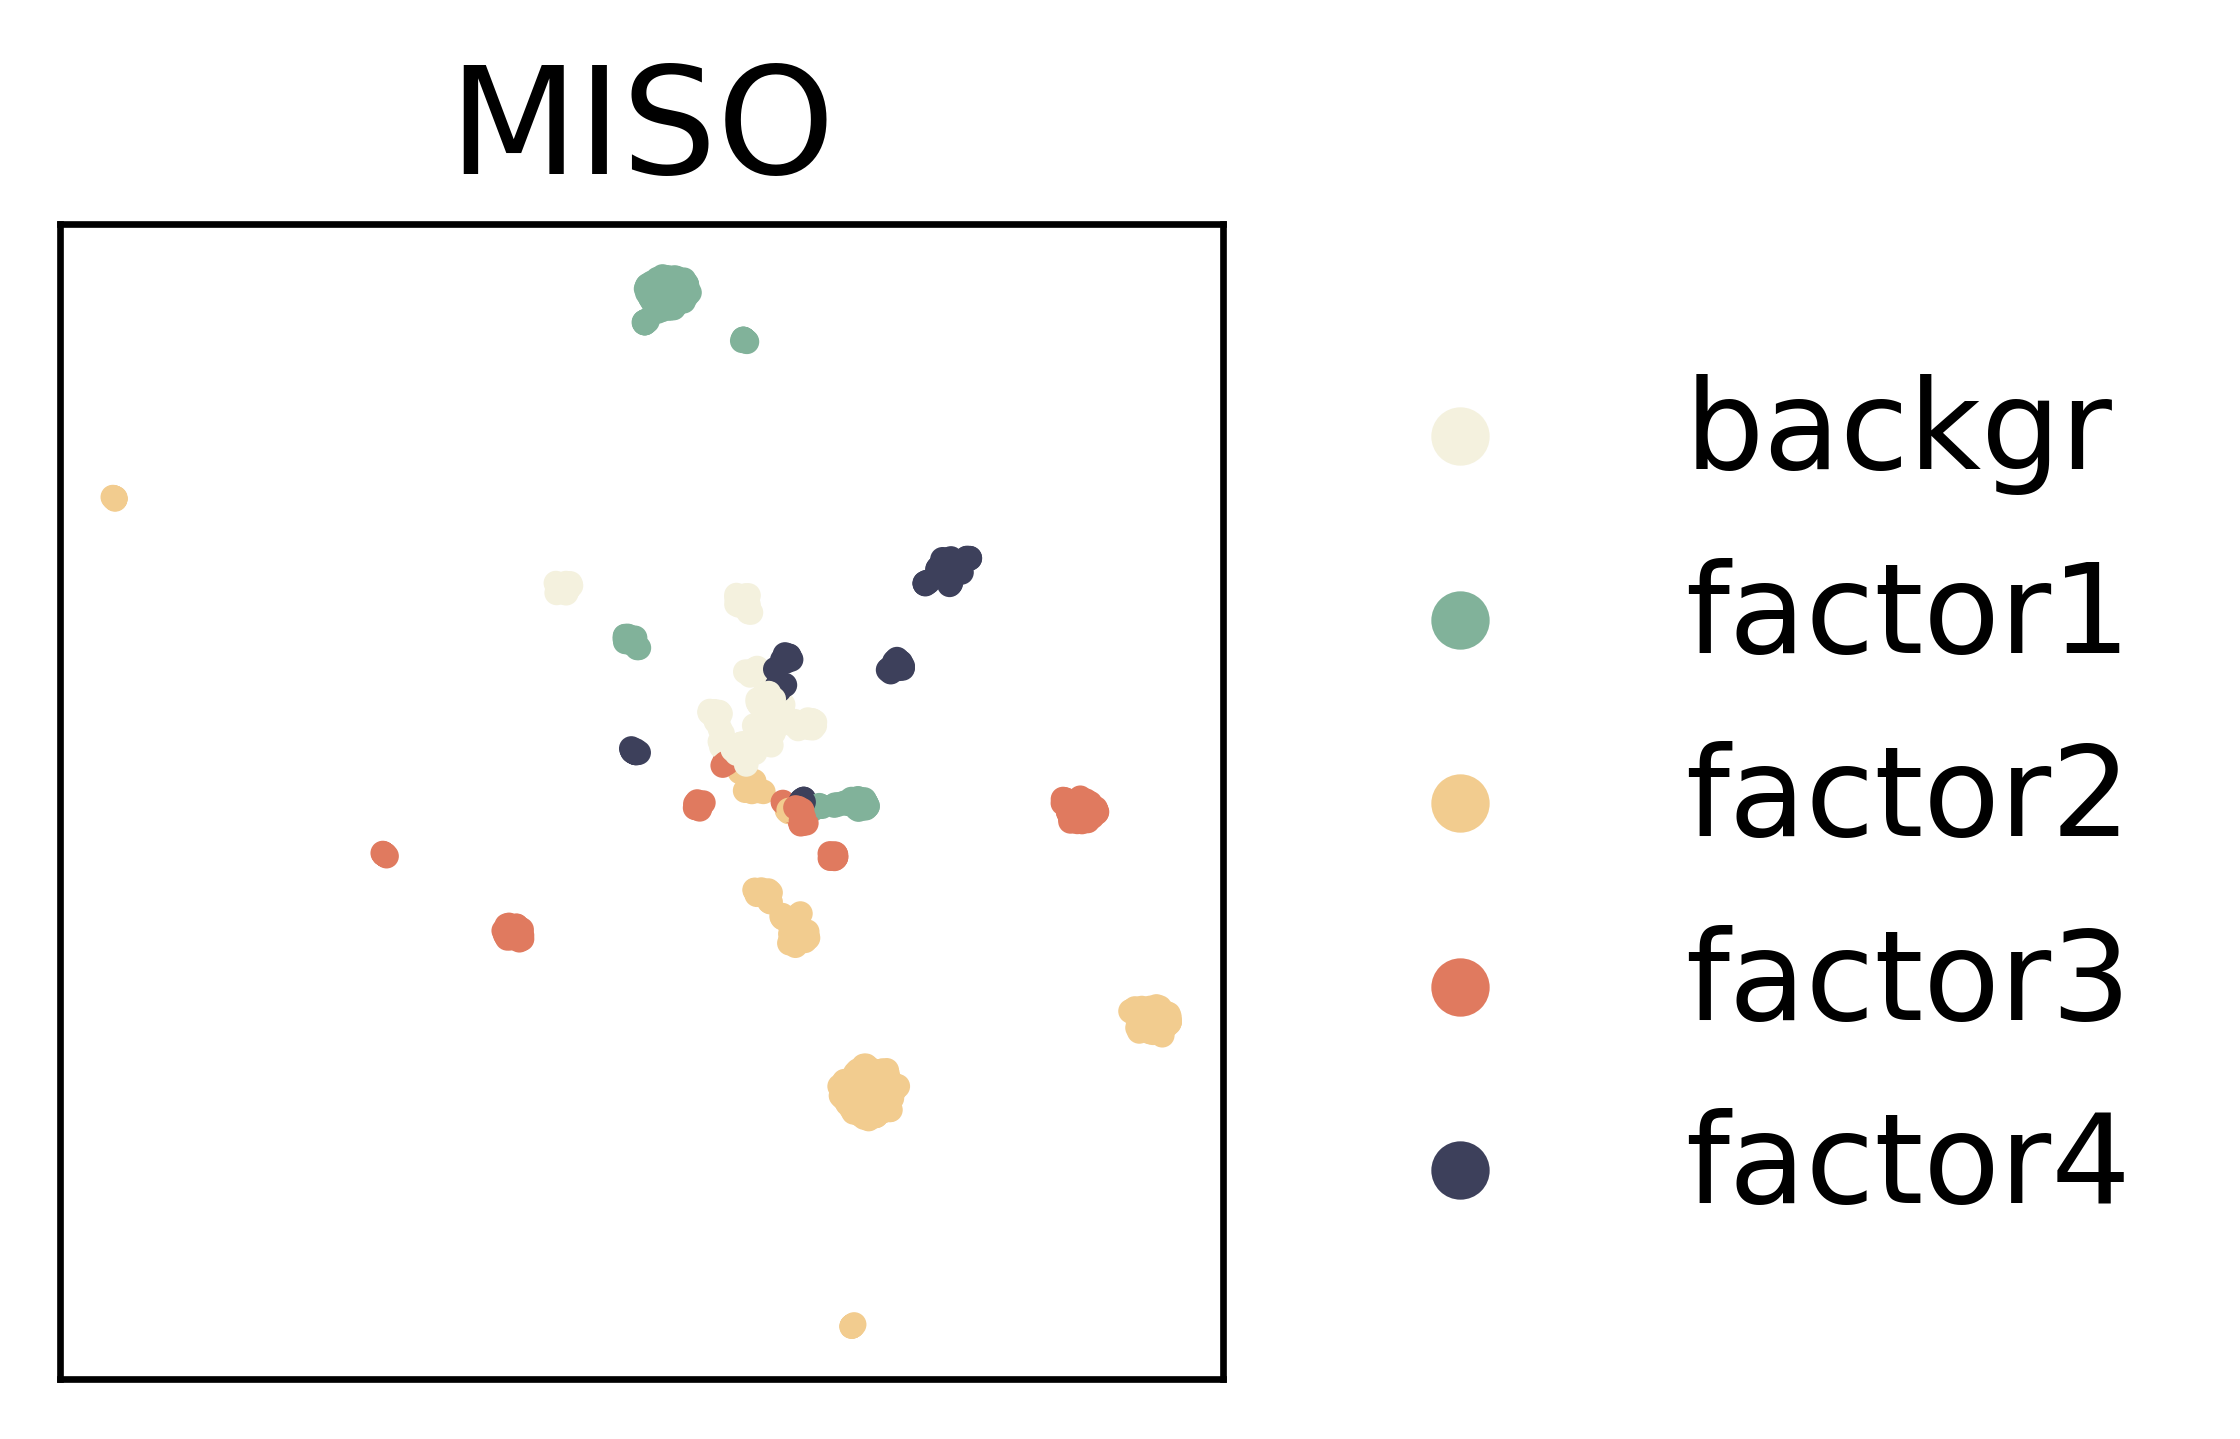

In [41]:
from umap import UMAP
umap_model = UMAP(n_neighbors=30, min_dist=0.2, n_components=2, random_state=42)

# Fit the model to your data and transform it
z_umap = umap_model.fit_transform(model.emb)
adata.obsm['umap'] = z_umap 

custom_palette = ['#f4f1de',  '#81b29a', '#f2cc8f', '#e07a5f','#3d405b',]

sc.pl.embedding(adata, basis='umap', title='MISO', color='leiden', s=35, show=False, palette=custom_palette)
plt.xlabel('')
plt.ylabel('')


In [59]:
adata.obsm['miso']=model.emb

In [60]:
adata.write('../../coral_storage/coral_results/simulation/miso_simu1.h5ad')